## Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import sqlalchemy
import seaborn as sn
import matplotlib.pyplot as plt
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from numpy import arange
# !pip install catboost
from catboost import CatBoostRegressor, Pool
from sklearn.inspection import permutation_importance

## Reading the data

In [4]:
df_all = pd.read_csv('sunny_foods_txns.csv')
datapoints = pd.read_pickle('outlier.pkl')

## Preprocessing

In [5]:
def preprocessing_binning(df_all, datapoints):
    df = df_all.loc[df_all['Transaction_Id'].isin(datapoints),:]
    df['flag'] = 1 
    #saving the dataframe to excel 
    df[['Product_Id','Product_Desc','flag']].groupby(['Product_Id','Product_Desc']).count().sort_values(by = 'flag', ascending = False).to_excel('product_count.xlsx')
    #printing the results 
    df_product_rowcount = df[['Product_Id','Product_Desc','flag']].groupby(['Product_Id','Product_Desc']).count().sort_values(by = 'flag', ascending = False)

    df_filtered = df[df.Product_Id.isin(df_product_rowcount.query('flag >= 1000').reset_index()['Product_Id'])]
    df_filtered.to_pickle('many_orders.pkl')

    df['flag'] = 1 

    #printing the results 
    df_customer_rowcount = df[['Customer_Id','flag']].groupby(['Customer_Id']).count().sort_values(by = 'flag', ascending = False)

    large = df_customer_rowcount.quantile(.66)
    small = df_customer_rowcount.quantile(.33)

    df_customer_copy = df_customer_rowcount.copy().reset_index()

    df_customer_copy['Customer_size'] = np.select([df_customer_copy.flag>large[0],df_customer_copy.flag<small[0]],['High','Low'],'Medium')

    df_customer_copy = df_customer_copy.drop(columns = 'flag')
    df_first_bin = pd.merge(df_filtered, df_customer_copy, how = 'inner', left_on = ['Customer_Id'], right_on = ['Customer_Id'])

    df_product_quantity = df_filtered[['Product_Id','Quantity']].groupby(['Product_Id']).sum().sort_values(by = 'Quantity', ascending = False)
    df_product_quantity = df_product_quantity.reset_index()
    large = df_product_quantity.quantile(.66)
    small = df_product_quantity.quantile(.33)
    df_product_quantity['product_total_quantity'] = np.select([df_product_quantity.Quantity>large[0],df_product_quantity.Quantity<small[0]],['High','Low'],'Medium')
    df_product_quantity = df_product_quantity.drop(columns = 'Quantity')
    df_second_bin = pd.merge(df_first_bin, df_product_quantity, how = 'inner', left_on = ['Product_Id'], right_on = ['Product_Id'])

    conditions = [
        (df_second_bin.Industry_Segment == 'Ind Full Line Bakery'),
        (df_second_bin.Industry_Segment == 'Ind Donut Shop'),
        (df_second_bin.Industry_Segment == 'Small Reg & Ind'),
        (df_second_bin.Industry_Segment == 'Small-Mid Size Mfg'),
        (df_second_bin.Industry_Segment == 'Chain Donut Shops'),
        (df_second_bin.Industry_Segment == 'Ind/Reg Chn Rst/Caf'),
        (df_second_bin.Industry_Segment == 'Ind Specialty Stores'),
        (df_second_bin.Industry_Segment == 'Chain Cake & Cupcake'),
        (df_second_bin.Industry_Segment == 'Ind Cake & Cupcake'),
        (df_second_bin.Industry_Segment == 'Broad-Line Dist'),
        (df_second_bin.Industry_Segment == 'Bakery Focused QSR'),
        (df_second_bin.Industry_Segment == 'Frz Snack QSR'),
        (df_second_bin.Industry_Segment == 'Chain Splty Stores'),
        (df_second_bin.Industry_Segment == 'Ntl Smkt Chains'),
        (df_second_bin.Industry_Segment == 'Chain Full Ln Bakery'),
        (df_second_bin.Industry_Segment == 'Bakery Distributors'),
        (df_second_bin.Industry_Segment == 'DDA Distributors'),
        (df_second_bin.Industry_Segment == 'Large Multi-Plnt Mfg'),
        (df_second_bin.Industry_Segment == 'Lg Reg Smkt Chains'),
        (df_second_bin.Industry_Segment == 'Non-Bakery Mfg'),
        (df_second_bin.Industry_Segment == 'Re-Distributor'),
        (df_second_bin.Industry_Segment == 'Grocery Whslr & Dist'),
        (df_second_bin.Industry_Segment == 'National Chain FSR'),
        (df_second_bin.Industry_Segment == 'QSR Restaurant'),
        (df_second_bin.Industry_Segment == 'Systems Distributor'),
    ]

    choices = ['Bakery','Donut Shop','Smkt','Manufacturing','Donut Shop','Restaurant','Specialty','Cake','Cake','Dist','Restaurant','Restaurant','Specialty',
              'Smkt','Bakery','Dist','Dist','Manufacturing','Smkt','Manufacturing','Dist','Dist','Restaurant','Restaurant','Dist']

    df_second_bin['Ind_Segment_Bin'] = np.select(conditions, choices, default = 'Other')

    conditions = [
        (df_second_bin.Region == 'USA'),
        (df_second_bin.Region == 'Canada')
    ]

    choices = ['USA','Canada']
    df_second_bin['Region_Bin'] = np.select(conditions, choices, default = 'Other')

    df_second_bin['profit_perc'] = ((df_second_bin['Price_Unit']-df_second_bin['Cost_Unit'])/df_second_bin['Cost_Unit'])*100

    keep_cols = ['Transaction_Id','Price_Unit',
       'Transaction_Date', 'Product_Id', 'Customer_Id',
       'SalesOrg', 'Cost', 'Quantity','Product_Level_1', 'Product_Level_2', 'Industry_Segment',
       'Channel', 'Region', 'Customer_Account_Type',  'Ind_Segment_Bin', 'Region_Bin']
    
    df_model = df_second_bin.loc[:,keep_cols]
    df_model['Transaction_Date'] = pd.to_datetime(df_model['Transaction_Date'])
    df_model.set_index(['Transaction_Id'], drop=True, inplace = True)

    # ## Extract date features
    df_model['MonthTransaction'] = df_model.loc[:,'Transaction_Date'].dt.month
    df_model['DayOfWeekTransaction'] = df_model.loc[:,'Transaction_Date'].dt.dayofweek
    ## Convert date features to object
    df_model['MonthTransaction'] = df_model['MonthTransaction'].astype(str)
    df_model['DayOfWeekTransaction'] = df_model['DayOfWeekTransaction'].astype(str)

    return df_model

# Catboost model

In [5]:
def catboost_model_results(df_model_f,idea):
    try:
        X = df_model_f.drop(columns = ['Price_Unit'])
        y = df_model_f.loc[:,'Price_Unit']
        if idea == 'idea1':
            cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
           'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment',
           'Ind_Segment_Bin', 'Region_Bin']
        elif idea == 'idea2':
            cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
           'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment','Customer_Id',
           'Ind_Segment_Bin', 'Region_Bin']
        for i in cat_features:
            X[i] = X[i].astype('category')
            X[i] = X[i].cat.codes
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                            random_state=1)
        
        if idea == 'idea1':

            pool_train = Pool(X_train, y_train,
                              cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
                   'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment',
                   'Ind_Segment_Bin', 'Region_Bin'])

            pool_test = Pool(X_test, cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
                   'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment',
                   'Ind_Segment_Bin', 'Region_Bin'])
            
         
            
        elif idea == 'idea2':
            pool_train = Pool(X_train, y_train, cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
               'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment','Customer_Id',
               'Ind_Segment_Bin', 'Region_Bin'])

            pool_test = Pool(X_test, cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
                   'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment','Customer_Id',
                   'Ind_Segment_Bin', 'Region_Bin'])

        params = {
        'depth' : [3,10,15,20],
        'n_estimators' : [200,400,600],
        'learning_rate' : [0.1, 0.2, 0.4]
        }
        cb = CatBoostRegressor(loss_function='RMSE', verbose=False)

        grid_search_result = cb.grid_search(params, 
                                           X=X_train, 
                                           y=y_train, 
                                           plot=False
                                           )
        best_params = grid_search_result['params']
        print(best_params)
        best_params['n_estimators'] = best_params.pop('iterations')
        best = CatBoostRegressor(depth = best_params['depth'],
                                 n_estimators = best_params['n_estimators'],
                                 learning_rate = best_params['learning_rate'],
                                 verbose=False)
        best.fit(pool_train)
        y_pred = best.predict(pool_test)

        cb_rmse = np.sqrt(mse(y_test, y_pred))
        print("RMSE in y units:", np.mean(cb_rmse))
        r2_cat = r2_score(y_test, y_pred)
        print("R2 score in y units:", np.mean(r2_cat))

        feature_importance = best.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
        plt.title('Feature Importance')
    
    except:
        print("All train targets are equal which is: ",df_model_f['Price_Unit'].unique())
    
    return

# Model Building

In [6]:
def model_building(df_model,idea):
    if idea == 'idea1':
        n = 10
        top_n = df_model.groupby(['Product_Id','Customer_Id']).size().reset_index().sort_values(by = [0], ascending  =False).iloc[0:n,:]
        for i in range(n):
            product_filter = df_model['Product_Id'] == top_n.iloc[i,0]
            customer_filter = df_model['Customer_Id'] == top_n.iloc[i,1]
            df_model_f = df_model[product_filter&customer_filter]
            print("Running for Product ID: ",top_n.iloc[i,0]," and customer id: ", top_n.iloc[i,1])
            cols = ['Transaction_Date', 'Product_Id','Customer_Id','Product_Level_2','Region']
            df_model_f = df_model_f.drop(columns=cols)
            df_model_f['SalesOrg'] = df_model_f['SalesOrg'].astype(str)
            catboost_model_results(df_model_f,idea)
    elif idea == 'idea2':
        n = 10
        top_n = df_model.groupby(['Product_Id']).size().reset_index().sort_values(by = [0], ascending  =False).iloc[0:n,:]
        for i in range(n):
            product_filter = df_model['Product_Id'] == top_n.iloc[i,0]
            df_model_f = df_model[product_filter]
            print("Running for Product ID: ",top_n.iloc[i,0])
            cols = ['Transaction_Date', 'Product_Id','Product_Level_2','Region']
            df_model_f = df_model_f.drop(columns=cols)
            df_model_f['SalesOrg'] = df_model_f['SalesOrg'].astype(str)
            catboost_model_results(df_model_f,idea)

Running for Product ID:  1395624  and customer id:  0001005960
All train targets are equal which is:  [18.78]
Running for Product ID:  2466060  and customer id:  0001005960
All train targets are equal which is:  [16.69]
Running for Product ID:  68296  and customer id:  0001005960
All train targets are equal which is:  [28.98]
Running for Product ID:  2497461  and customer id:  0001005960
All train targets are equal which is:  [15.27]
Running for Product ID:  1265744  and customer id:  0001005960
All train targets are equal which is:  [19.3]
Running for Product ID:  1038472  and customer id:  0001005961
All train targets are equal which is:  [68.35]
Running for Product ID:  2384915  and customer id:  0001034170
All train targets are equal which is:  [17.37]
Running for Product ID:  435918  and customer id:  0001034170

bestTest = 0.5762800986
bestIteration = 197

0:	loss: 0.5762801	best: 0.5762801 (0)	total: 222ms	remaining: 7.77s

bestTest = 0.7187402154
bestIteration = 197

1:	loss: 0

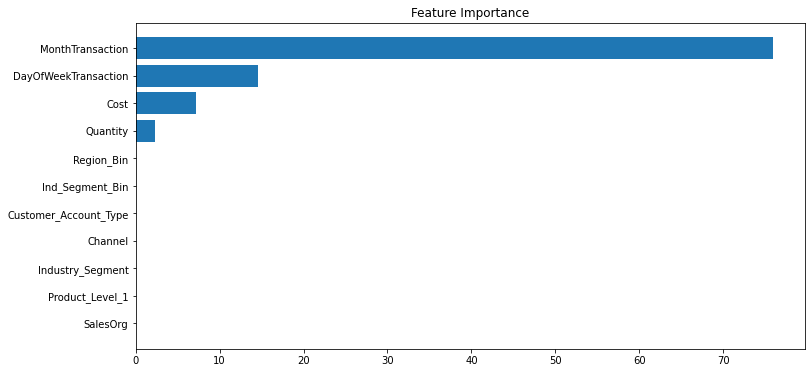

In [7]:
df_model = preprocessing_binning(df_all, datapoints)
model_building(df_model,'idea1') #Product customer combination

Running for Product ID:  917958

bestTest = 1.483482233
bestIteration = 199

0:	loss: 1.4834822	best: 1.4834822 (0)	total: 519ms	remaining: 18.2s

bestTest = 1.365244074
bestIteration = 199

1:	loss: 1.3652441	best: 1.3652441 (1)	total: 1.14s	remaining: 19.3s

bestTest = 1.271310749
bestIteration = 199

2:	loss: 1.2713107	best: 1.2713107 (2)	total: 1.73s	remaining: 19s

bestTest = 1.371593436
bestIteration = 399

3:	loss: 1.3715934	best: 1.2713107 (2)	total: 2.9s	remaining: 23.2s

bestTest = 1.268541801
bestIteration = 399

4:	loss: 1.2685418	best: 1.2685418 (4)	total: 4.1s	remaining: 25.4s

bestTest = 1.172405801
bestIteration = 399

5:	loss: 1.1724058	best: 1.1724058 (5)	total: 5.29s	remaining: 26.5s

bestTest = 1.316254576
bestIteration = 599

6:	loss: 1.3162546	best: 1.1724058 (5)	total: 7.06s	remaining: 29.2s

bestTest = 1.211471771
bestIteration = 599

7:	loss: 1.2114718	best: 1.1724058 (5)	total: 8.84s	remaining: 30.9s

bestTest = 1.112645341
bestIteration = 599

8:	loss: 1.1126


bestTest = 1.853454797
bestIteration = 199

10:	loss: 1.8534548	best: 1.8534548 (10)	total: 15.6s	remaining: 35.4s

bestTest = 1.701424248
bestIteration = 199

11:	loss: 1.7014242	best: 1.7014242 (11)	total: 18.8s	remaining: 37.5s

bestTest = 1.851226094
bestIteration = 399

12:	loss: 1.8512261	best: 1.7014242 (11)	total: 25.2s	remaining: 44.5s

bestTest = 1.663377494
bestIteration = 399

13:	loss: 1.6633775	best: 1.6633775 (13)	total: 31.4s	remaining: 49.4s

bestTest = 1.588426583
bestIteration = 399

14:	loss: 1.5884266	best: 1.5884266 (14)	total: 37.8s	remaining: 52.9s

bestTest = 1.731331257
bestIteration = 599

15:	loss: 1.7313313	best: 1.5884266 (14)	total: 47.1s	remaining: 58.9s

bestTest = 1.58386592
bestIteration = 599

16:	loss: 1.5838659	best: 1.5838659 (16)	total: 56.4s	remaining: 1m 3s

bestTest = 1.538074336
bestIteration = 599

17:	loss: 1.5380743	best: 1.5380743 (17)	total: 1m 5s	remaining: 1m 5s

bestTest = 1.980104405
bestIteration = 199

18:	loss: 1.9801044	best: 1.


bestTest = 1.14270291
bestIteration = 399

21:	loss: 1.1427029	best: 1.0607501 (17)	total: 6m 37s	remaining: 4m 13s

bestTest = 1.114677922
bestIteration = 398

22:	loss: 1.1146779	best: 1.0607501 (17)	total: 8m 55s	remaining: 5m 2s

bestTest = 1.185625129
bestIteration = 399

23:	loss: 1.1856251	best: 1.0607501 (17)	total: 11m 16s	remaining: 5m 38s

bestTest = 1.113806672
bestIteration = 597

24:	loss: 1.1138067	best: 1.0607501 (17)	total: 14m 45s	remaining: 6m 29s

bestTest = 1.101783416
bestIteration = 599

25:	loss: 1.1017834	best: 1.0607501 (17)	total: 18m 16s	remaining: 7m 1s

bestTest = 1.181431093
bestIteration = 599

26:	loss: 1.1814311	best: 1.0607501 (17)	total: 21m 51s	remaining: 7m 17s
Estimating final quality...
Training on fold [0/3]

bestTest = 1.078314707
bestIteration = 598

Training on fold [1/3]

bestTest = 1.088082607
bestIteration = 598

Training on fold [2/3]

bestTest = 1.066682066
bestIteration = 599

{'depth': 10, 'iterations': 600, 'learning_rate': 0.4}
RMSE


bestTest = 4.598914933
bestIteration = 199

1:	loss: 4.5989149	best: 4.5989149 (1)	total: 987ms	remaining: 16.8s

bestTest = 4.168765235
bestIteration = 199

2:	loss: 4.1687652	best: 4.1687652 (2)	total: 1.52s	remaining: 16.7s

bestTest = 4.595096447
bestIteration = 399

3:	loss: 4.5950964	best: 4.1687652 (2)	total: 2.51s	remaining: 20.1s

bestTest = 4.213127854
bestIteration = 399

4:	loss: 4.2131279	best: 4.1687652 (2)	total: 3.46s	remaining: 21.5s

bestTest = 3.888035666
bestIteration = 395

5:	loss: 3.8880357	best: 3.8880357 (5)	total: 4.43s	remaining: 22.2s

bestTest = 4.329969316
bestIteration = 599

6:	loss: 4.3299693	best: 3.8880357 (5)	total: 6.06s	remaining: 25.1s

bestTest = 4.033491472
bestIteration = 599

7:	loss: 4.0334915	best: 3.8880357 (5)	total: 7.56s	remaining: 26.5s

bestTest = 3.772157794
bestIteration = 599

8:	loss: 3.7721578	best: 3.7721578 (8)	total: 9.04s	remaining: 27.1s

bestTest = 3.993477654
bestIteration = 199

9:	loss: 3.9934777	best: 3.7721578 (8)	tota


bestTest = 1.19539035
bestIteration = 399

12:	loss: 1.1953903	best: 1.1347860 (11)	total: 23.3s	remaining: 41.2s

bestTest = 1.112200262
bestIteration = 399

13:	loss: 1.1122003	best: 1.1122003 (13)	total: 29.4s	remaining: 46.1s

bestTest = 1.076986094
bestIteration = 399

14:	loss: 1.0769861	best: 1.0769861 (14)	total: 35.4s	remaining: 49.5s

bestTest = 1.119468338
bestIteration = 599

15:	loss: 1.1194683	best: 1.0769861 (14)	total: 44.3s	remaining: 55.4s

bestTest = 1.071799629
bestIteration = 599

16:	loss: 1.0717996	best: 1.0717996 (16)	total: 53.4s	remaining: 59.6s

bestTest = 1.056520957
bestIteration = 596

17:	loss: 1.0565210	best: 1.0565210 (17)	total: 1m 2s	remaining: 1m 2s

bestTest = 1.27249773
bestIteration = 199

18:	loss: 1.2724977	best: 1.0565210 (17)	total: 2m 5s	remaining: 1m 52s

bestTest = 1.182595472
bestIteration = 199

19:	loss: 1.1825955	best: 1.0565210 (17)	total: 3m 10s	remaining: 2m 32s

bestTest = 1.218381007
bestIteration = 197

20:	loss: 1.2183810	best: 

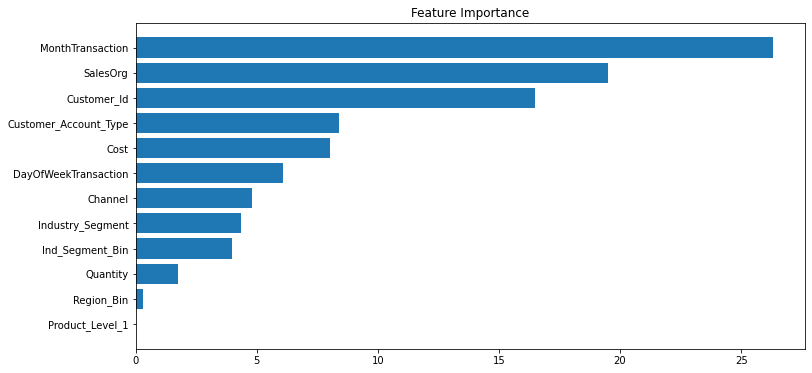

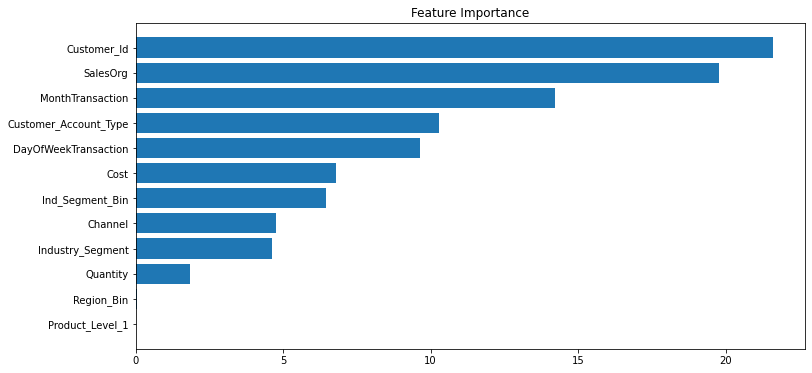

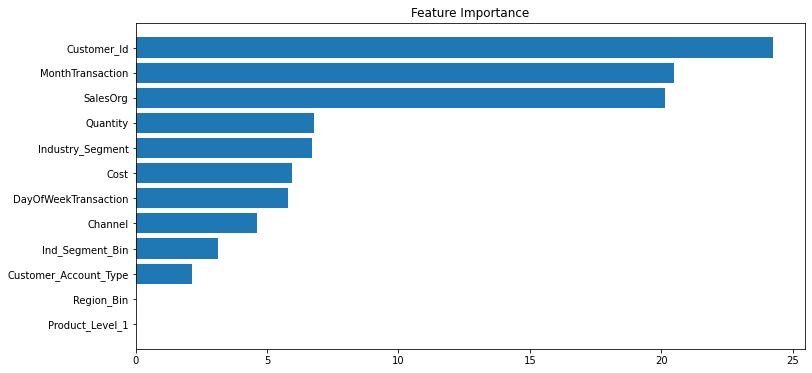

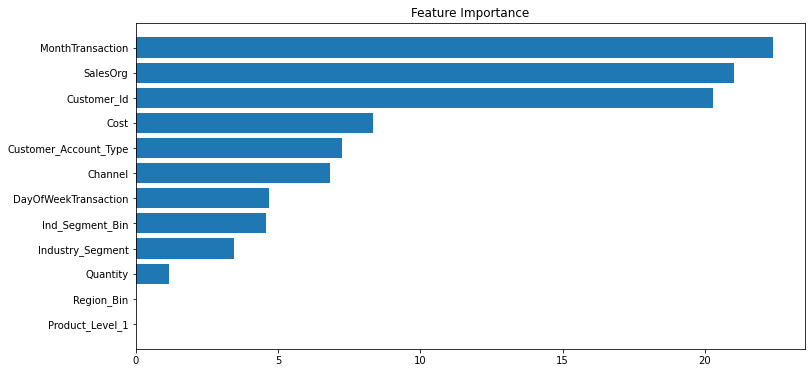

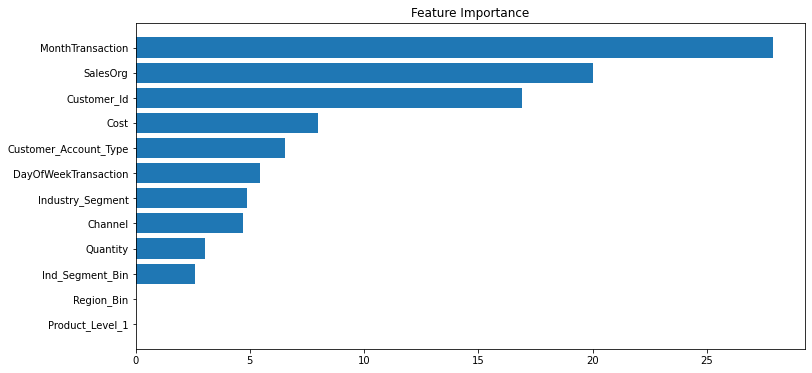

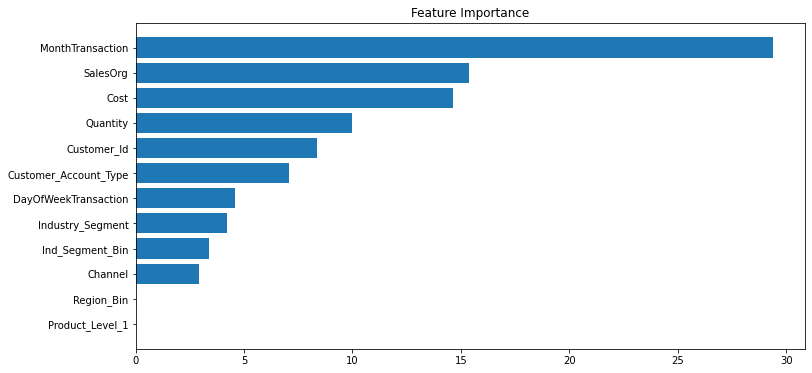

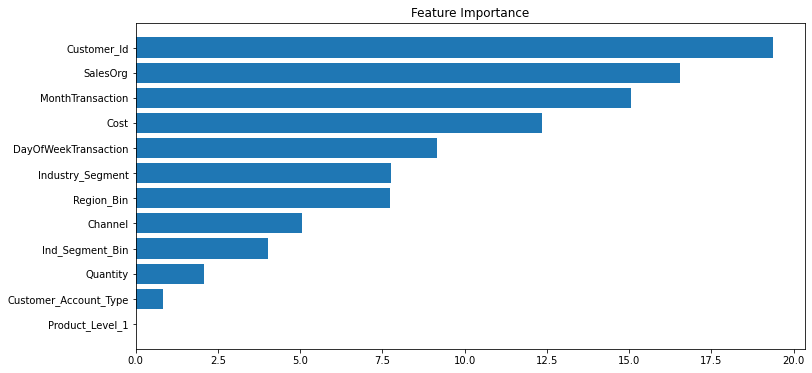

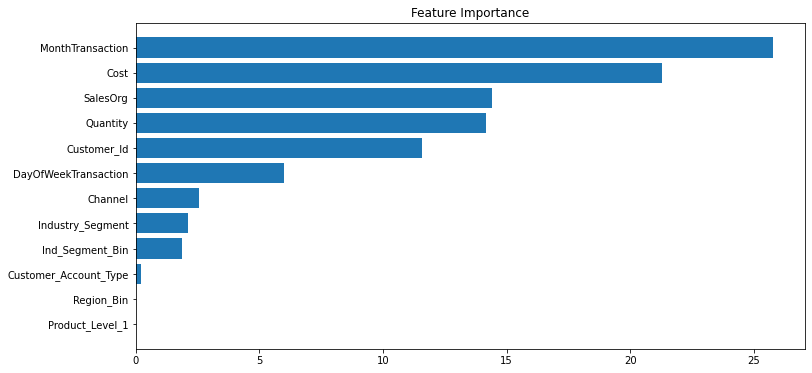

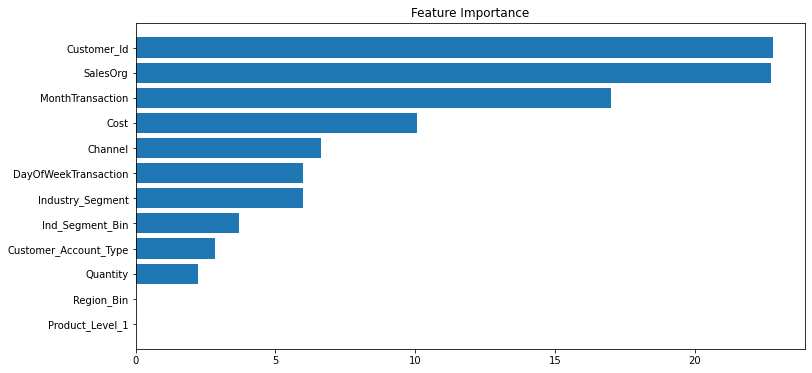

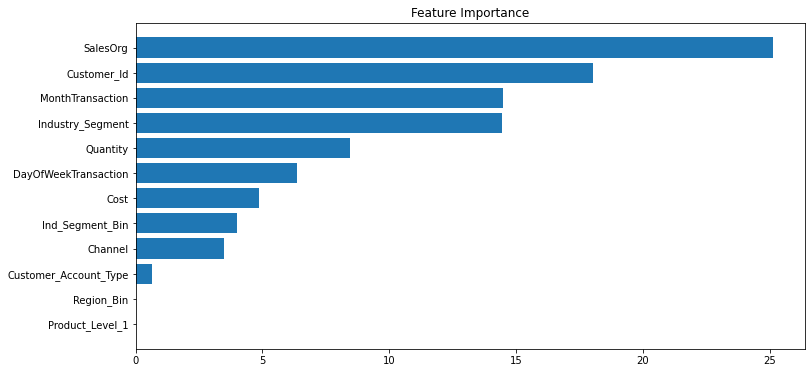

In [8]:
model_building(df_model,'idea2')

# KNN as a Prototype

New Product, Customer Agnostic

In [15]:
import pickle
def catboost_model_results(df_model_f, product_id):
    try:
        X = df_model_f.drop(columns = ['Price_Unit','Customer_Id'])
        y = df_model_f.loc[:,'Price_Unit']
        cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
       'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment',
       'Ind_Segment_Bin', 'Region_Bin']
        for i in cat_features:
            X[i] = X[i].astype('category')
            X[i] = X[i].cat.codes

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                            random_state=1)

        pool_train = Pool(X_train, y_train, cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
           'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment',
           'Ind_Segment_Bin', 'Region_Bin'])

        pool_test = Pool(X_test, cat_features = ['SalesOrg', 'Product_Level_1', 'Channel',
               'Customer_Account_Type','MonthTransaction','DayOfWeekTransaction','Industry_Segment',
               'Ind_Segment_Bin', 'Region_Bin'])

        cb = CatBoostRegressor(n_estimators=200,
                           loss_function='RMSE',
                           learning_rate=0.4,
                           depth=3, task_type='CPU',
                           random_state=1,
                           verbose=False)

        cb.fit(pool_train)
        y_pred = cb.predict(pool_test)

        cb_rmse = np.sqrt(mse(y_test, y_pred))
        print("RMSE in y units:", np.mean(cb_rmse))
        r2_cat = r2_score(y_test, y_pred)
        print("R2 score in y units:", np.mean(r2_cat))

        filename = str(product_id) + 'model.pkl'
        pickle.dump(cb, open(filename,'wb'))

        feature_importance = cb.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
        plt.title('Feature Importance')
        
        
    
    except:
        print("All train targets are equal which is: ",df_model_f['Price_Unit'].unique())
    
    return

In [16]:
def model_building(df_model):
    n = 10
    top_n = df_model.groupby(['Product_Id']).size().reset_index().sort_values(by = [0], ascending  =False).iloc[0:n,:]
    for i in range(n):
        product_filter = df_model['Product_Id'] == top_n.iloc[i,0]
        df_model_f = df_model[product_filter]
        print("Running for Product ID: ",top_n.iloc[i,0])
        cols = ['Transaction_Date', 'Product_Id','Product_Level_2','Region']
        df_model_f = df_model_f.drop(columns=cols)
        df_model_f['SalesOrg'] = df_model_f['SalesOrg'].astype(str)
        catboost_model_results(df_model_f, top_n.iloc[i,0])

Running for Product ID:  917958
RMSE in y units: 1.267395272247268
R2 score in y units: 0.7876599295989134
Running for Product ID:  2405191
RMSE in y units: 2.4296948947805577
R2 score in y units: 0.6557779565070481
Running for Product ID:  25437
RMSE in y units: 2.618333212950927
R2 score in y units: 0.76986008829482
Running for Product ID:  6874
RMSE in y units: 4.229098655194863
R2 score in y units: 0.7781160850366462
Running for Product ID:  2498154
RMSE in y units: 1.761441204868608
R2 score in y units: 0.8008571136735265
Running for Product ID:  2505321
RMSE in y units: 3.0556449517852275
R2 score in y units: 0.9012243686665373
Running for Product ID:  640517
RMSE in y units: 2.7359639280949706
R2 score in y units: 0.7369334705988517
Running for Product ID:  2505496
RMSE in y units: 4.232844181767108
R2 score in y units: 0.8970901532109254
Running for Product ID:  7997
RMSE in y units: 4.167314638414492
R2 score in y units: 0.7747616867541612
Running for Product ID:  1150226
RMSE

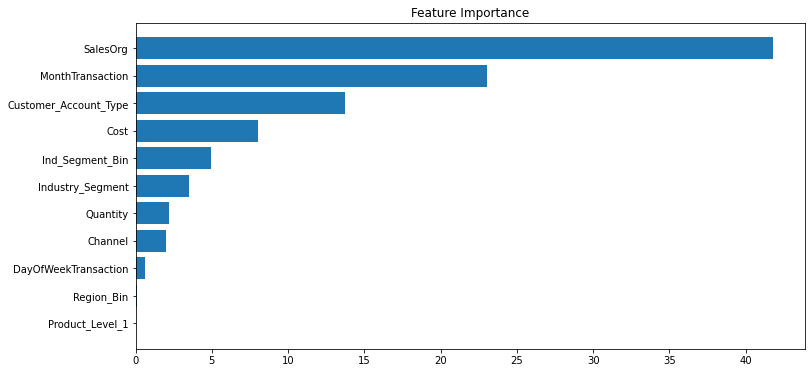

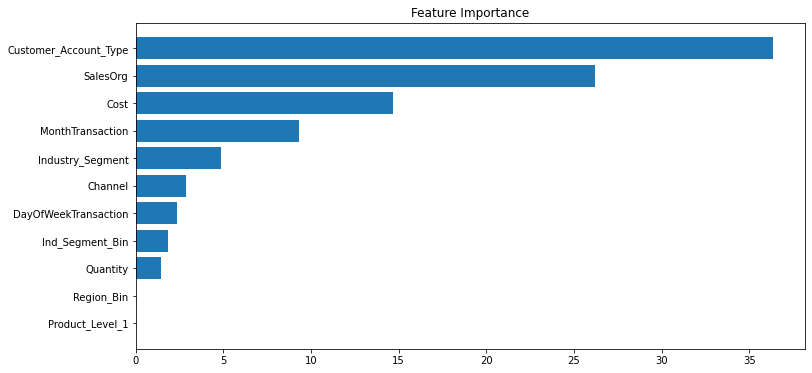

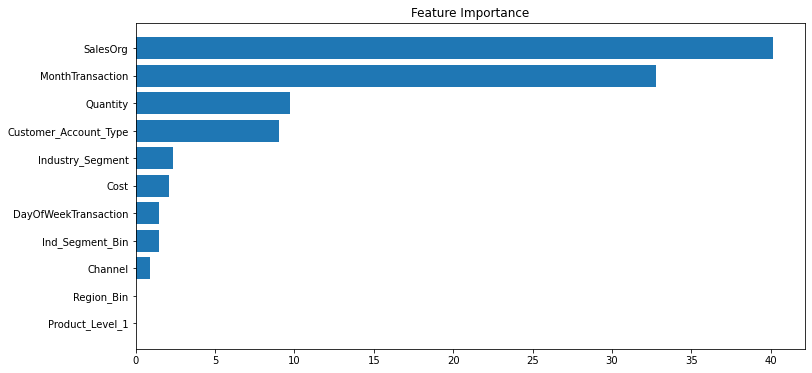

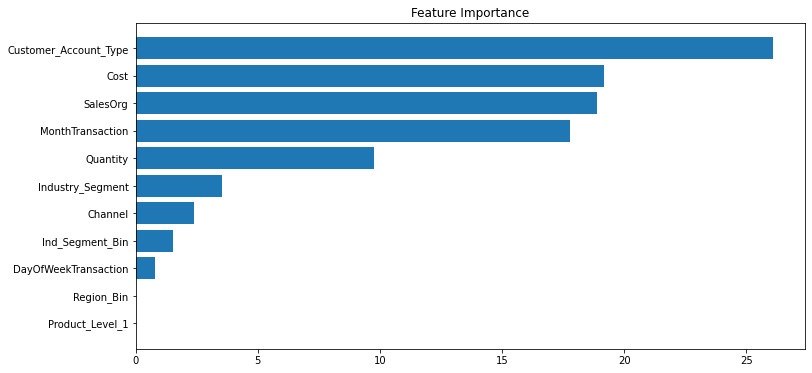

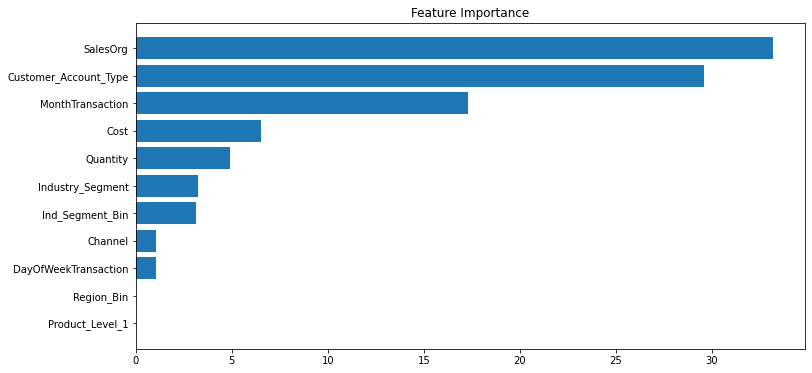

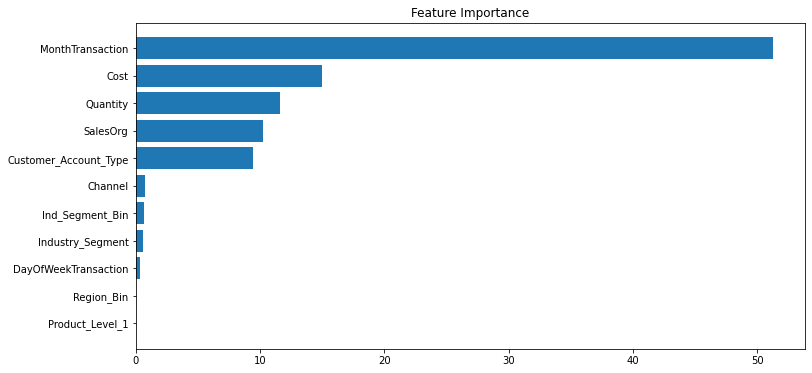

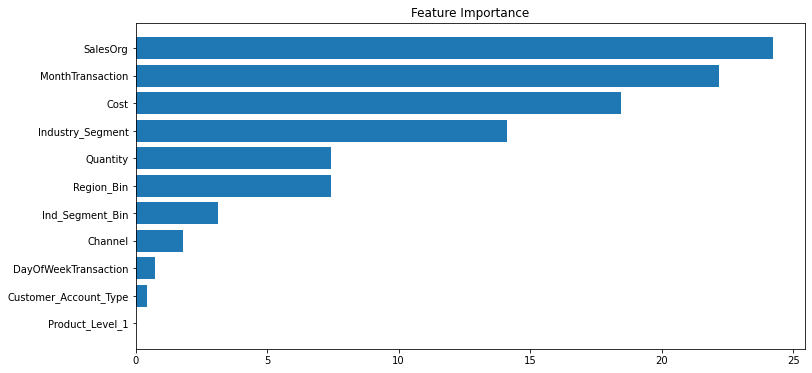

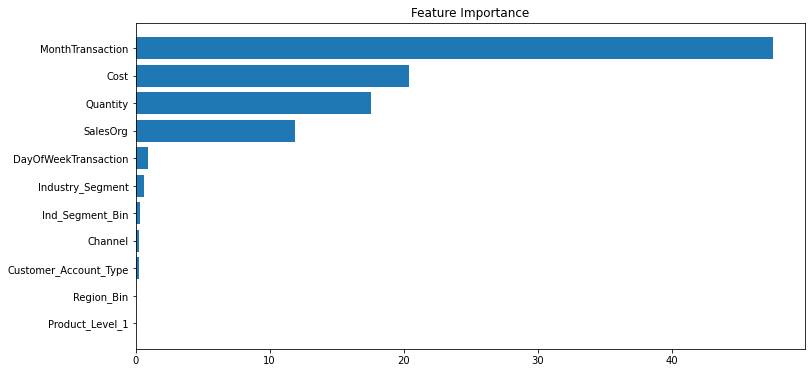

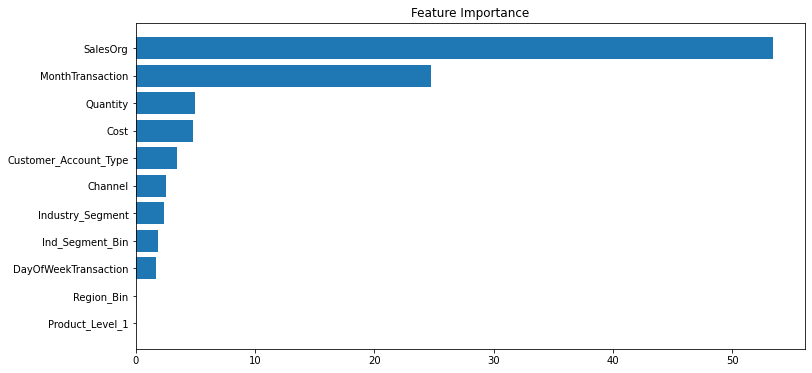

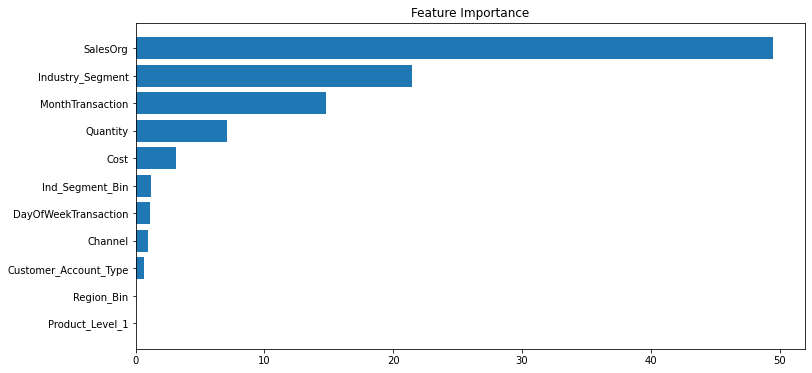

In [17]:
df_model = preprocessing_binning(df_all, datapoints)
model_building(df_model)

In [117]:
def predict_func(product_id, X_topredict):
#     X should contain - ['SalesOrg','Cost','Quantity', 'Product_Level_1', 'Industry_Segment','Channel',
#        'Customer_Account_Type','Ind_Segment_Bin', 'Region_Bin','MonthTransaction','DayOfWeekTransaction']
    try:
        filename = str(product_id) + 'model.pkl'
        model = pickle.load(open(filename,'rb'))
#         print(model.get_all_params())
        y_pred = model.predict(X_topredict)
        return y_pred
    
    except:
        print("Product not found")


In [118]:
def euclidean(row1, row2):
    distance = 0
    for i in range(1,len(row1)):
        distance += (float(row1[i]) - float(row2[i]))**2
    return np.sqrt(distance)

def knn_func(df_model, test_row, number_of_neighbours):
    n = 10
    top_n = df_model.groupby(['Product_Id']).size().reset_index().sort_values(by = [0], ascending  =False).iloc[0:n,:]
    df_model_top_n = df_model[df_model['Product_Id'].isin(top_n['Product_Id'])]
#     training_set = df_model_top_n.reset_index()[['Product_Id','Product_Level_1','Product_Level_2','Cost']]
#     training_set = training_set.groupby(['Product_Id']).agg({'Product_Level_1':'max',
#                                                              'Product_Level_2':'max','Cost':'mean'}).reset_index()
    training_set = df_model_top_n.reset_index()[['Product_Id','Cost']]
    training_set = training_set.groupby(['Product_Id']).agg({'Cost':'mean'}).reset_index()
    neighbours = []
    distance = []
    training_set = training_set.values.tolist ()
    for train_row in training_set:
        dist = euclidean(train_row, test_row)
        distance.append((train_row, dist))
    distance.sort(key = lambda x:x[1])
    for i in range(number_of_neighbours):
        neighbours.append(distance[i][0])
    
    return neighbours

In [119]:
def modeling_knn_testing_prediction(df_model, product_id):
    number_of_neighbours = 3
    cost_product = df_model[df_model['Product_Id']==product_id]['Cost'].mean()
    neighbours = knn_func(df_model,[product_id,cost_product],number_of_neighbours)
    neighbouring_products = [int(x[0]) for x in neighbours]
    X_topredict = df_model[df_model['Product_Id']==product_id][['SalesOrg','Cost','Quantity', 'Product_Level_1',
                                                             'Industry_Segment','Channel','Customer_Account_Type',
                                                             'Ind_Segment_Bin', 'Region_Bin','MonthTransaction',
                                                             'DayOfWeekTransaction']].iloc[0,:]
    X_topredict['SalesOrg'] = X_topredict['SalesOrg'].astype(int)
    y_prediction = []
    for i in neighbouring_products:
        y_pred = predict_func(int(i),X_topredict)
        y_prediction.append(y_pred)
    return sum(y_prediction)/len(y_prediction)

In [120]:
modeling_knn_testing_prediction(df_model,2497015)

28.43970501898674

In [121]:
df_model[df_model['Product_Id']==2497015].iloc[0,:]

Price_Unit                              38.67
Transaction_Date          2021-02-09 00:00:00
Product_Id                            2497015
Customer_Id                        0001041762
SalesOrg                               1020.0
Cost                                    29.39
Quantity                                  1.0
Product_Level_1          Packaging & Supplies
Product_Level_2               Bakery Supplies
Industry_Segment          Ind/Reg Chn Rst/Caf
Channel                           Foodservice
Region                                    USA
Customer_Account_Type                     MKT
Ind_Segment_Bin                    Restaurant
Region_Bin                                USA
MonthTransaction                            2
DayOfWeekTransaction                        1
Name: 2580026:90, dtype: object